# Inicjalizacja środowiska

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from math import log

import warnings
warnings.filterwarnings('ignore')

## Funkcje pomocnicze

In [2]:
#Sprawdza skuteczność modelu na zbiorze walidacyjnym w zależności od wartości współczynnika regularyzacji
def searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, min, max, step):
    scores = []
    values = []
    for C in np.arange(min, max, step):
        model = LogisticRegression(random_state=None, solver=solver, penalty=penalty, C=C).fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = metrics.accuracy_score(y_val, y_pred)
        scores.append(score)
        values.append(C)
    #Zwraca wektory skuteczności oraz wartości C
    return scores, values

#Sprawdza maksymalną skuteczność modelu na zbiorze walidacyjnym spośród wszystkich zbadanych wartości współczynnika regularyzacji
def testModelParameters(solver, penalty, X_train, y_train, X_val, y_val, plot=True, print_result=True):
    val_scores, values = searchBestCValue(solver, penalty, X_train, y_train, X_val, y_val, 0.01, 40, 1)
    if (plot):
        plt.figure()
        plt.plot(values, val_scores)
        plt.show()
    max = np.max(val_scores)
    idx = val_scores.index(max)
    C = values[idx]
    if(print_result):
        print("Największa wartość Accuracy na zbiorze walidacyjnym: %.4f \ndla współczynnika C = %.4f" %(max, C))
    return solver, penalty, C, max


# Dane wypełnione medianami
Do tworzenia modelu wykorzystuję dane wypełnione medianami podczas analizy zbioru.

## Wczytanie danych

In [3]:
data = pd.read_csv("data/imputated_data.csv")
data = data.drop(['Imputated'], axis=1)
data = data.drop(['Unnamed: 0'], axis=1)

# Wstępne przetwarzanie danych

## Podział na cechy opisujące oraz cechę opisywaną.

In [405]:
y = data['Outcome']
X = data.drop(["Outcome"], axis=1)

## Dodanie dodatkowych cech

Funkcje interakcji najlepiej sprawdzają się w przypadku cech, które na wykresie cecha1(cecha2) układają się mniej więcej wzdłuż funkcji x=y oraz wraz z x rośnie prawdopodobieństwo wystąpienia pozytywnej decyzji. Z pomocą wykresów korelacji znalazłem jeden taki przypadek: Glucose oraz BMI.

Nałożenie logarytmu na cechę jest dobrym pomysłem w przypadku cech ze skośnym rozkładem, ponieważ pomaga rozdzielić wartości które oryginalnie stanowią tylko małą część zakresu.

In [406]:
X['GlucoseSquared'] = X['Glucose'].apply(lambda x: x**2)
X['GlucoseBMI'] = X['Glucose'] * X['BMI']

X['PregnanciesLog'] = X['Pregnancies'].apply(lambda x:log(x) if(x>0) else 0)
X['DPFLog'] = X['DiabetesPedigreeFunction'].apply(lambda x:log(x) if(x>0) else 0)
X['InsulinLog'] = X['Insulin'].apply(lambda x:log(x) if(x>0) else 0)
X['AgeLog'] = X['Age'].apply(lambda x:log(x) if(x>0) else 0)

In [407]:
X = X.drop(['Pregnancies','Insulin','DiabetesPedigreeFunction','Age'],axis=1)

<AxesSubplot: xlabel='InsulinLog', ylabel='Density'>

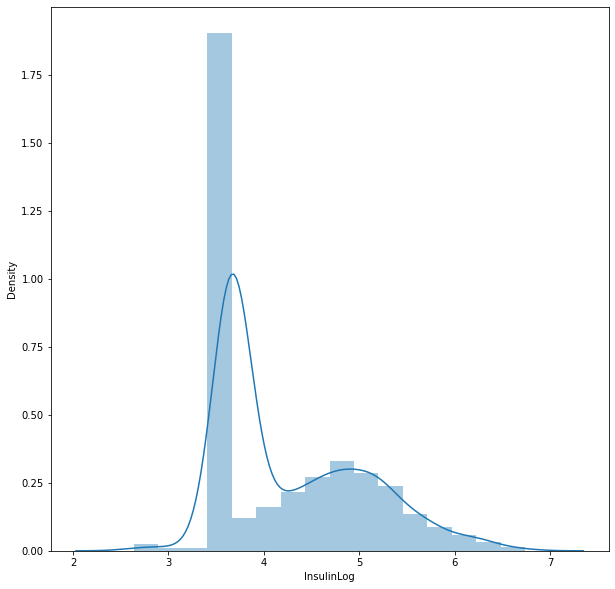

In [282]:
plt.figure(figsize=(10,10))
sns.distplot(X.InsulinLog)

## Normalizacja
Normalizację stosuję, ponieważ cechy posiadają różniące się od siebie zakresy. Wartości skrajne z cech posiadających rozkłady prawoskośne zostały wyeliminowane przez zastosowanie logarytmów.

In [408]:
nscaler = MinMaxScaler() 
cols_to_norm = X.columns.values
for col in cols_to_norm:
    cols= [col]
    nscaler.fit(X[cols])
    X[cols] = nscaler.transform(X[cols])

## Podział danych
* Podział na zbiory X (cechy opisujące) oraz Y (cecha opisywana). Dla tego zbioru Y to "Outcome", czyli diagnoza.
* Podział na zbiory Train/Test/Val - procentowy podział w komentarzu funkcji splitDataset()

In [10]:
def splitDataset(X, y, random_state=0, print_result=False):
    #Podział Train 60%, Test 20%, Val 20%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    #0.5 * 0.4 = 0.2
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)
    if (print_result):
        print("Zbiór podzielony: TRAIN: %i, VAL: %i, TEST: %i" % (X_train.shape[0],X_val.shape[0],X_test.shape[0]))
    return X_train, y_train, X_test, y_test, X_val, y_val

In [409]:
X_train, y_train, X_test, y_test, X_val, y_val = splitDataset(X, y, random_state=0, print_result=True)

Zbiór podzielony: TRAIN: 451, VAL: 151, TEST: 150


### Wybór ilości cech

Do doboru cech wykorzystuje metodę zachłanną. Model ma jednak włączoną regularyzację Lasso, dzięki czemu przy okazji będzie pozbywał się lub redukował wpływ tych mniej znaczących cech zmniejszając ich szansę na zostanie wybraną w danym etapie. Dla każdego etapu dodatkowo liczone jest współczynnik regularyzacji oferujący najlepszy wynik miary Accuracy. Zaimplementowałem to, ponieważ dla różnych ilości cech modele działają najlepiej dla różnych wartości C. Ponieważ stosuję regularyzację L1 to może wystąpić zjawisko redukcji lub wyzerowania cech w dalszych etapach. Wezmę to pod uwagę przy ostatecznym wyborze metody i siły regularyzacji.

In [23]:
def greedyFeaturesSearch(X_train, y_train, X_val, y_val):
    features = X_train.columns.values.tolist()
    result_features = []

    acc_scores = []
    best_c_acc_scores = []
    feature_numbers = []

    model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=4.1)
    for n in range(0,len(features)):
        tmp_max_score = 0
        tmp_test_score = 0
        best_features = []
        for i,val in enumerate(features):
            tmp_features = result_features.copy()
            tmp_features.append(val)
            solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[tmp_features], y_train, X_val[tmp_features], y_val, plot=False, print_result=False)
            score = max
            if( score > tmp_max_score ):
                tmp_max_score = score
                best_features = tmp_features
        result_features = best_features
        print("Dla %i cech najlepsza średnia wartość walidacji krzyżowej wynosi %.4f dla zbioru cech:\n%s" % (len(best_features), tmp_max_score, str(best_features)))
        acc_scores.append(tmp_max_score)
        feature_numbers.append(len(best_features))
        solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[best_features], y_train, X_val[best_features], y_val, plot=False, print_result=False)
        best_c_acc_scores.append(max)
        print("Dla najlepszego współczynnika C = %f średnia skuteczność na zbiorze walidacyjnym wynosi %.4f" % (C,max))
        print("___________________________________________________________________________")
        features.remove(best_features[len(best_features)-1])
    return feature_numbers, acc_scores

Dla 1 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.7881 dla zbioru cech:
['GlucoseBMI']
Dla najlepszego współczynnika C = 1.010000 średnia skuteczność na zbiorze walidacyjnym wynosi 0.7881
___________________________________________________________________________
Dla 2 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.8411 dla zbioru cech:
['GlucoseBMI', 'AgeLog']
Dla najlepszego współczynnika C = 1.010000 średnia skuteczność na zbiorze walidacyjnym wynosi 0.8411
___________________________________________________________________________
Dla 3 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.8477 dla zbioru cech:
['GlucoseBMI', 'AgeLog', 'InsulinLog']
Dla najlepszego współczynnika C = 1.010000 średnia skuteczność na zbiorze walidacyjnym wynosi 0.8477
___________________________________________________________________________
Dla 4 cech najlepsza średnia wartość walidacji krzyżowej wynosi 0.8477 dla zbioru cech:
['GlucoseBMI', 'AgeLog', 'InsulinLog',

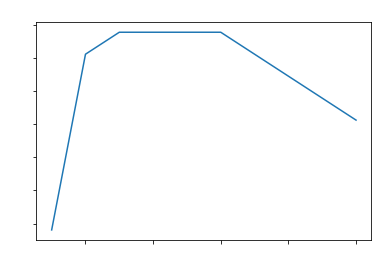

In [410]:
feature_numbers, cv_scores = greedyFeaturesSearch(X_train, y_train, X_val, y_val)
plt.figure()
plt.plot(feature_numbers, cv_scores)
titleobj = plt.title("Skuteczność na zbiorze walidacyjnym od ilości cech")
ax = plt.gca()
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    tick_label.set_color('white')
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    tick_label.set_color('white')
plt.setp(titleobj, color = 'w')
plt.show()

In [411]:
features = ['GlucoseBMI', 'AgeLog', 'InsulinLog', 'BloodPressure', 'SkinThickness', 'BMI']

Dla małej ilości cech (1-2) skuteczność jest niska, ponieważ model jest niedouczony, posiada duże obciążenie. Następnie dla ilości cech (3-6) skuteczność jest teoretycznie optymalna. Dla wyższej ilości cech skuteczność znowu spada, ponieważ wariancja modelu się zwiększa.

Ponieważ wybór został dokonany metodą zachłanną to wybieram największy zbiór cech spośród tych o najlepszej skuteczności, aby uniknąć zbyt dużego dopasowania wyboru cech do zbioru uczącego.

Warto zauważyć, że aż 3 z 6 wybranych cech to cechy dodane lub transformowane wcześniej. 2 cechy, czyli SkinThickness oraz InsulinLog są cechami które miały duże braki.

# Dobór parametrów

## Metoda regularyzacji
Celem etapu jest zdecydowanie, którą metodę regularyzacji zastosować przy ostatecznym uczeniu modelu.

Do decyzji wykorzystam znajomość cech charakterystycznych obu metod oraz funkcję pomocniczą badającą maksymalną skuteczność modelu na zbiorze walidacyjnym w zależności od współczynnika regularyzacji.

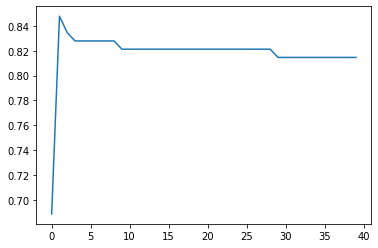

Największa wartość Accuracy na zbiorze walidacyjnym: 0.8477 
dla współczynnika C = 1.0100


In [412]:
solver, penalty, C, max = testModelParameters('liblinear','l1', X_train[features], y_train, X_val[features], y_val)

In [413]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l1', C=1).fit(X_train[features], y_train)
model.coef_

array([[ 7.59579255,  1.75344046, -0.44956982, -0.38868239,  0.        ,
         0.        ]])

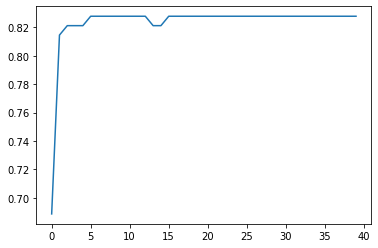

Największa wartość Accuracy na zbiorze walidacyjnym: 0.8278 
dla współczynnika C = 5.0100


In [414]:
solver, penalty, C, max = testModelParameters('liblinear','l2', X_train[features], y_train, X_val[features], y_val)

Ostatecznie okazało się, że regularyzacja L1 dla 6 zachłannie wybranych cech 2 z nich zerowała, co skutkowało przeuczeniem modelu. Zdecydowałem się więc na regularyzację L2 i ręczne zwiększenie współczynnika regularyzacji do momentu, gdy wyniki walidacji krzyżowej nie będą wskazywać na silne przeuczenie.

In [415]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l2', C=2).fit(X_train[features], y_train)
model.coef_

array([[ 5.99226953,  1.8429058 , -0.36113071, -0.76667523, -0.0114242 ,
         0.30950646]])

In [416]:
cross_val_score(model, X_train, y_train, cv=5)

array([0.78021978, 0.71111111, 0.77777778, 0.7       , 0.72222222])

# Wynik

In [417]:
model = LogisticRegression(random_state=0, solver='liblinear', penalty='l2', C=2).fit(X_train[features], y_train)

In [439]:
[model.coef_, features]

[array([[ 5.99226953,  1.8429058 , -0.36113071, -0.76667523, -0.0114242 ,
          0.30950646]]),
 ['GlucoseBMI',
  'AgeLog',
  'InsulinLog',
  'BloodPressure',
  'SkinThickness',
  'BMI']]

Zdecydowanie najbardziej znaczącą cechą jest nowo dodana funkcja interakcji GlucoseBMI, co było do przewidzenia na podstawie korelacji cech w zbiorze. Zaskakująca jednak jest obecność cechy AgeLog, ponieważ nic nie wskazywało na to że znajdzie się wśród tych najbardziej wpływających na chorobę.

# Analiza utworzonego modelu

## Wykres
Model uczony jest wieloma cechami, jednak po współczynnikach widać, że jeden z nich jest kluczowy dlatego można wykreślić bardzo poglądowy wykres regresji.

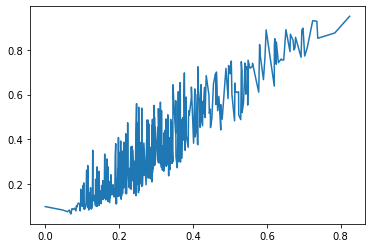

In [440]:
sorted = X_train.sort_values(by="GlucoseBMI")
model_values = (model.predict_proba(sorted[features]))
model_values[:,1]

plt.plot(sorted['GlucoseBMI'], model_values[:,1])

Wykres narysowany tą metodą przypomina kształtem funkcję sigmoidalną. Zakłócenia są powodowane tym, że ostateczny wynik zależy również od wielu innych cech.

## Miary 
Zbadanie skuteczności na zbiorze testowym przy użyciu miar.

In [441]:
y_pred = model.predict(X_test[features])

In [442]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1score = metrics.f1_score(y_test, y_pred)

In [443]:
print("Accuracy: %f\nPrecision: %f\nRecall: %f\nF1Score: %f" % (accuracy, precision, recall, f1score))

Accuracy: 0.773333
Precision: 0.723404
Recall: 0.618182
F1Score: 0.666667


Na zbiorze testowym wyniki nie są już takie dobre jak na walidacyjnym, ale wciąż skuteczność jest większa niż 75%.

In [446]:
model.classes_

array([0, 1], dtype=int64)

In [445]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(metrics.confusion_matrix(y_test, y_pred))
print(tn,fp,fn,tp)

[[82 13]
 [21 34]]
82 13 21 34


## Wykorzystanie
Celem jest prosta odpowiedź na pytanie: co by się stało gdyby ten model został użyty w realnej sytuacji?

Sama skuteczność ~75% nie jest najgorsza, ale ponieważ decyzją jest diagnoza choroby to najważniejsza jest ilość False Negative, czyli sytuacji kiedy chory zostanie odesłany do domu. Wykorzystując fakt, że regresja logistyczna zwraca prawdopodobieństwa przynależności obiektu do danej klasy można ręcznie zdefiniować progi tak, aby za wszelką cenę uniknąć takiego zjawiska.

In [387]:
model.classes_

array([0, 1], dtype=int64)

In [426]:
skierowania = 0
poprawne = 0
FP = 0
FN = 0
for idx in range(0, len(X)):
    row = X.iloc[idx,:][features].to_numpy().reshape(1,-1)
    prediction = model.predict_proba(row)[0]
    if(prediction[0] > 0.883):
        result = 0
    elif(prediction[1] > 0.5):
        result = 1 
    else: result = -1
    true_value = y.iloc[idx]
    if (result == -1):
        skierowania += 1
    elif (result == true_value):
        poprawne += 1
    else: 
        if(true_value == 1):
            FN +=1
        else: 
            FP +=1
print("Poprawne predykcje: %i\nFalse Positive: %i\nFalse Negative: %i\nSkierowania na dodatkowe badania: %i" %(poprawne, FP, FN, skierowania))

Poprawne predykcje: 211
False Positive: 52
False Negative: 0
Skierowania na dodatkowe badania: 489


Po ręcznym zdefiniowaniu progów udało się wykluczyć wszystkie False Negative na całym zbiorze. Sprawiło to jednak, że ponad połowę pacjentów trzeba było skierować na dodatkowe badania. Pozytywnym aspektem jest to, że ok. 27% pacjentów udało się sklasyfikować z ogromnym prawdopodobieństem, że to dobra predykcja. Taki wynik nie jest taki zły na jaki wygląda, ponieważ trzeba pamiętać że nawet jeden przypadek False Negative jest całkowicie niedopuszczalny. 


In [432]:
skierowania = 0
poprawne = 0
FP = 0
FN = 0
for idx in range(0, len(X)):
    row = X.iloc[idx,:][features].to_numpy().reshape(1,-1)
    prediction = model.predict_proba(row)[0]
    if(prediction[0] > 0.805):
        result = 0
    elif(prediction[1] > 0.5):
        result = 1 
    else: result = -1
    true_value = y.iloc[idx]
    if (result == -1):
        skierowania += 1
    elif (result == true_value):
        poprawne += 1
    else: 
        if(true_value == 1):
            FN +=1
        else: 
            FP +=1
print("Poprawne predykcje: %i\nFalse Positive: %i\nFalse Negative: %i\nSkierowania na dodatkowe badania: %i" %(poprawne, FP, FN, skierowania))

Poprawne predykcje: 338
False Positive: 52
False Negative: 6
Skierowania na dodatkowe badania: 356


Gdyby z jakiekogolwiek powodu próg dozwolonych FN wynosiłby np. 1% (zamiast 0%) to wtedy model pozwoliłby na poprawną diagnozę prawie połowy pacjentów. 

False Positive, czyli sytuacje kiedy całkowicie zdrowy zostanie zdiagnozowany jako chory nie są aż takie złe. Co prawda pacjent będzie niepotrzebnie zestresowany, ale każdego zdiagnozowanego i tak trzeba przebadać dokładniej, aby mieć 100% pewności więc ostatecznie nie zostałyby podjęte żadne kroki w leczeniu.